In [2]:
import os
import json
from itertools import islice
import pandas as pd
from upsetplot import UpSet, from_indicators
from matplotlib import pyplot as plt
import seaborn as sns

data_dir = os.path.normpath(os.path.join(os.path.abspath(''), '..', 'data'))
graphs_dir = os.path.normpath(os.path.join(os.path.abspath(''), '..', 'graphs'))

distinct_colors = [
    "#332626", "#7f4400", "#7f7700", "#608075", "#40bfff", "#0000f2", "#ff80a2", "#735656", "#ffaa00", "#eeff00", "#40ffbf", "#0061f2", "#73698c", "#7f0011", "#ff2200", "#fff2bf", "#41f200", "#40f2ff", "#000066", "#f780ff", "#ffa280", "#332900", "#008022", "#005266", "#000073"
]

default_figsize_x, default_figsize_y = plt.rcParams["figure.figsize"]

sns.reset_defaults()
sns.set_theme(context="paper", font="Latin Modern Sans", font_scale=1.1, palette="colorblind")
plt.ion()


In [4]:
def json_obj_from_file_to_matplotlib(path, max_rows=None, reverse=True):
    with open(os.path.join(data_dir, path)) as f:
        data = json.load(f)
        slice = islice(data.items(), 0, max_rows)
        items = list(slice)[::-1] if reverse else slice
        return zip(*items)


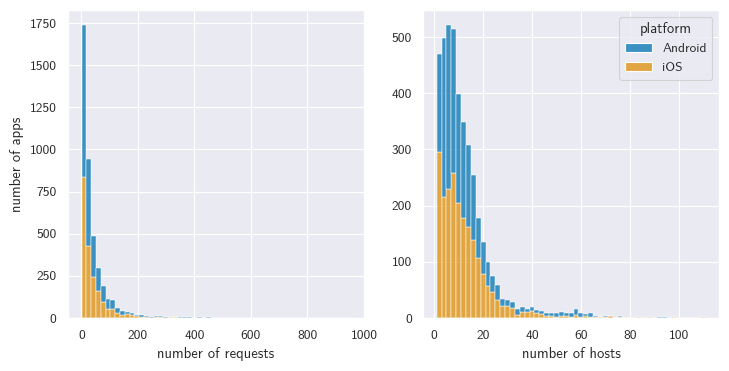

In [215]:
csv = pd.read_csv(os.path.join(data_dir, 'app_traffic.csv'), on_bad_lines='error', converters={
                  'platform': lambda p: 'Android' if p == 'android' else 'iOS'})


fig, axes = plt.subplots(1, 2, figsize=[1.4*default_figsize_x, default_figsize_y])
sns.histplot(data=csv.loc[(csv['request_count'] <= 1000)], x='request_count', ax=axes[0],
             binwidth=17, hue='platform', multiple='stack', legend=False)
axes[0].set_xlabel('number of requests')
axes[0].set_ylabel('number of apps')

sns.histplot(data=csv, x='host_count', ax=axes[1],
             binwidth=2, hue='platform', multiple='stack')
axes[1].set_xlabel('number of hosts')
axes[1].set_ylabel('')

fig.savefig(os.path.join(graphs_dir, 'requests_hosts_per_app.pdf'),
            bbox_inches="tight", pad_inches=0)


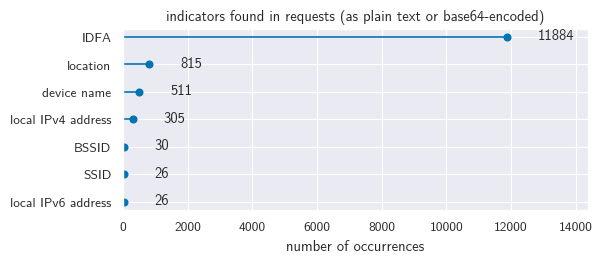

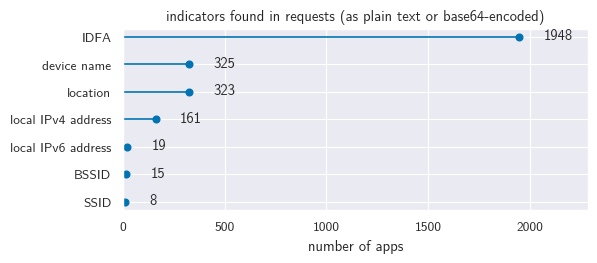

In [216]:
for type in ['occurrences', 'apps']:
    data = list(json_obj_from_file_to_matplotlib(f'indicator_{type}.json'))

    fig, ax = plt.subplots(figsize=[default_figsize_x, default_figsize_y / 1.7])
    ax.set_title('indicators found in requests (as plain text or base64-encoded)')
    ax.set_xlabel(f'number of {type}')
    ax.stem(*data, orientation='horizontal', basefmt='none')
    _, x_max = ax.get_xlim()
    x_delta = 950 if type == 'occurrences' else 120
    ax.set_xlim(0, x_max + x_delta*2)

    for i, v in enumerate(data[1]):
        ax.text(v + x_delta, i - 0.1, str(v))


Text(0.5, 1.0, 'Consent dialog violations')

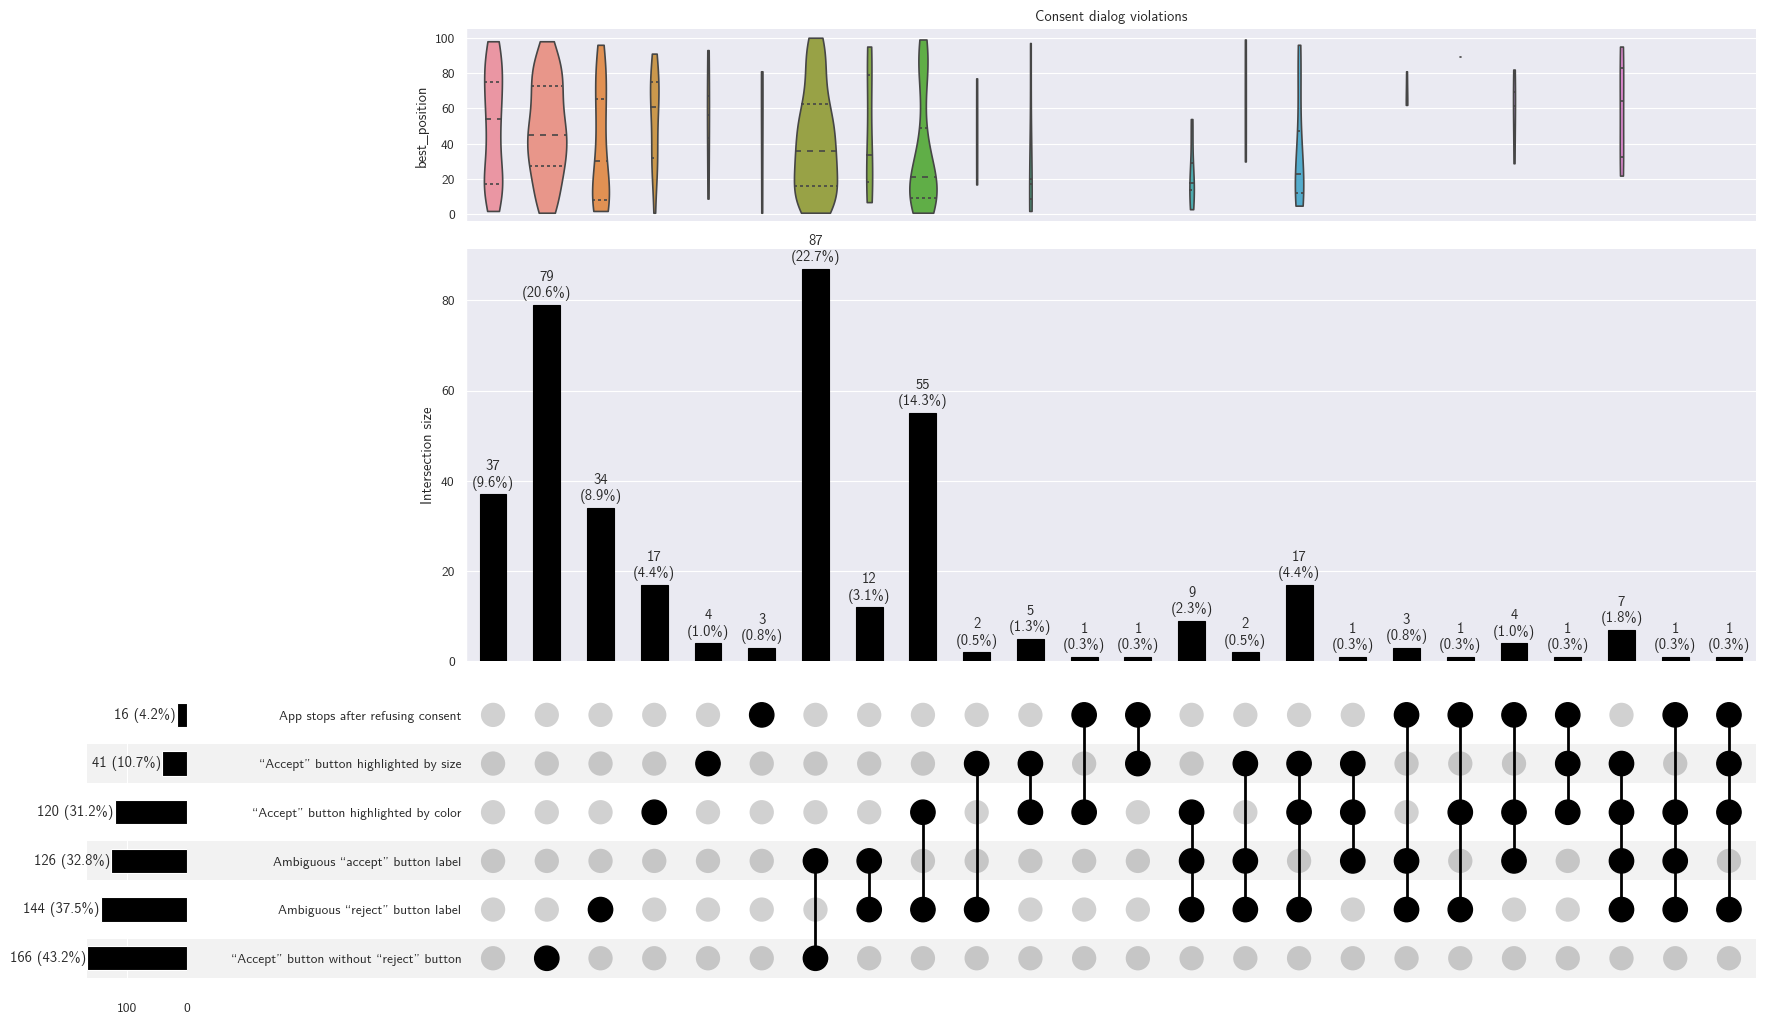

In [217]:
csv = pd.read_csv(os.path.join(data_dir, 'dialogs.csv'), on_bad_lines='error', header=0, names=[
                  'name', 'platform', 'version', 'categories', 'best_position', 'best_position_set', 'verdict', 'App stops after refusing consent', '“Accept” button highlighted by color', 'Ambiguous “accept” button label', 'Ambiguous “reject” button label', '“Accept” button highlighted by size', '“Accept” button without “reject” button'], converters={'platform': lambda p: 'Android' if p == 'android' else 'iOS'})
dialogs = csv.loc[(csv['verdict'] == 'dialog') |
                  (csv['verdict'] == 'maybe_dialog')]
data = from_indicators(
    lambda data: data.select_dtypes(bool), data=dialogs)

upset = UpSet(data, show_counts=True, show_percentages=True,
                intersection_plot_elements=8,
              element_size=50)
# upset.add_stacked_bars(by='platform', colors=cm.Pastel1,
#                        elements=13, title='Count by platform')
# upset.add_stacked_bars(by='best_position_set', colors=distinct_colors, elements=13, title='Count by best top chart position')
# upset.add_stacked_bars(by='categories', colors=distinct_colors, elements=13, title='Count by category')
upset.add_catplot(value='best_position', kind='violin', elements=4, cut=0, scale='count', inner='quartiles')
# upset.add_catplot(value='best_position', kind='swarm', elements=8)
upset.plot()
plt.title('Consent dialog violations')

# Note: Platform bar plot is misleading as Android has fewer apps than iOS.


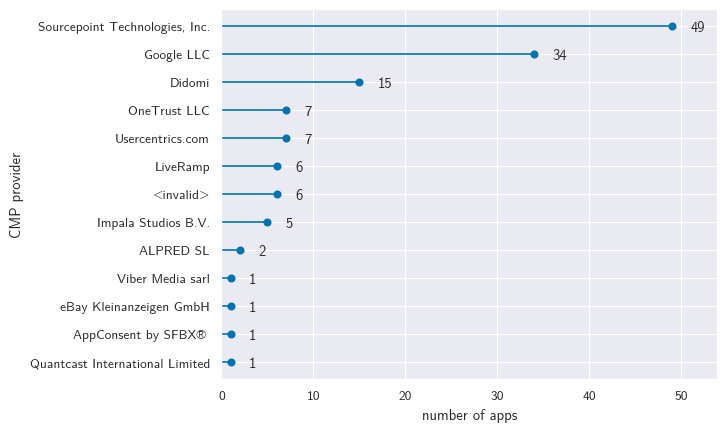

In [218]:
data = list(json_obj_from_file_to_matplotlib('tcf_cmps.json', None, True))

fig, ax = plt.subplots()
ax.set_ylabel('CMP provider')
ax.set_xlabel('number of apps')
ax.stem(*data, orientation='horizontal', basefmt='none')
_, x_max = ax.get_xlim()
ax.set_xlim(0, x_max + 2.5)

for i, v in enumerate(data[1]):
    ax.text(v + 2, i - 0.17, str(v))

fig.savefig(os.path.join(graphs_dir, 'tcf_cmps.pdf'), bbox_inches="tight", pad_inches=0)


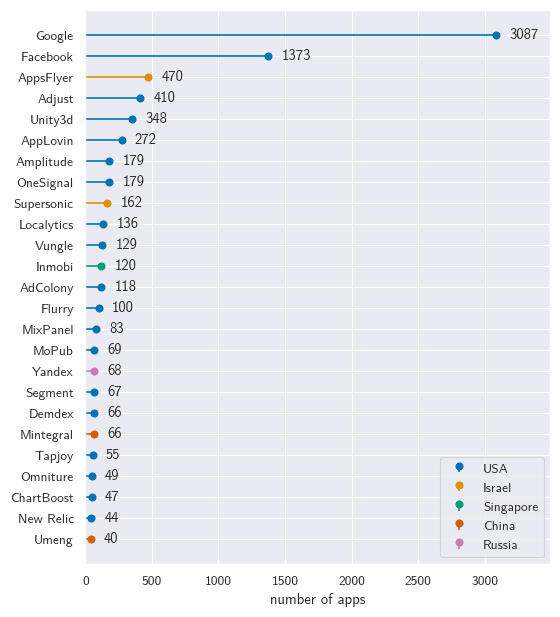

In [219]:
trackers, tracker_counts = json_obj_from_file_to_matplotlib(
    'exodus_tracker_counts.json', 25)

fig, ax = plt.subplots(figsize=[default_figsize_x, default_figsize_y * 1.8])
ax.set_xlabel('number of apps')

tracker_countries = {
    "Google": "USA",  # https://policies.google.com/privacy
    "Facebook": "USA",  # https://www.facebook.com/about/privacy
    "AppsFlyer": "Israel",  # https://www.appsflyer.com/legal/services-privacy-policy/
    "Adjust": "USA",  # https://www.adjust.com/terms/privacy-policy/
    "Unity3d": "USA",  # https://unity3d.com/legal/privacy-policy
    "AppLovin": "USA",  # https://www.applovin.com/privacy/
    "OneSignal": "USA",  # https://onesignal.com/privacy_policy
    "Supersonic": "Israel",  # https://supersonic.com/privacy/
    "Amplitude": "USA",  # https://amplitude.com/privacy
    "Localytics": "USA",  # https://uplandsoftware.com/localytics/app-privacy/
    "Vungle": "USA",  # https://vungle.com/privacy/
    "AdColony": "USA",  # https://www.adcolony.com/privacy-policy/
    "Inmobi": "Singapore",  # https://opencorporates.com/companies/sg/200811408G
    "Flurry": "USA",  # https://developer.yahoo.com/flurry/legal-privacy/terms-service/flurry-analytics-terms-service.html
    "MixPanel": "USA",  # https://mixpanel.com/legal/privacy-policy/
    "Mintegral": "China",  # https://www.mintegral.com/en/privacy/
    "Segment": "USA",  # https://segment.com/legal/privacy-04-2018/
    "Yandex": "Russia",  # https://yandex.com/legal/confidential/
    "MoPub": "USA",  # https://www.mopub.com/en/legal/privacy
    "Demdex": "USA",  # https://experienceleague.adobe.com/docs/audience-manager/user-guide/reference/demdex-calls.html
    "Tapjoy": "USA",  # https://www.tapjoy.com/legal/general/privacy-policy/
    "ChartBoost": "USA",  # https://answers.chartboost.com/en-us/articles/200780269
    "Omniture": "USA",  # https://en.wikipedia.org/wiki/Omniture
    "New Relic": "USA",  # https://newrelic.com/termsandconditions/privacy
    "Umeng": "China",  # https://reports.exodus-privacy.eu.org/en/trackers/119/
}
# This is apparently how you get an ordered set, see: https://stackoverflow.com/a/53657523
countries = list(dict.fromkeys(tracker_countries.values()))

for idx, country in enumerate(countries):
    trackers_in_country = filter(
        lambda tracker: tracker_countries[tracker] == country, trackers)
    indices = [trackers.index(tracker) for tracker in trackers_in_country]
    counts = [tracker_counts[i] for i in indices]
    ax.stem(indices, counts, orientation='horizontal', basefmt='none',
            linefmt=f'C{idx}-', markerfmt=f'C{idx}o', label=country)

ax.set_yticks(range(0, len(trackers)), trackers)

_, x_max = ax.get_xlim()
ax.set_xlim(0, x_max + 250)

ax.legend()

for i, v in enumerate(tracker_counts):
    ax.text(v + 100, i - 0.2, str(v))

fig.savefig(os.path.join(graphs_dir, 'exodus_tracker_counts.pdf'),
            bbox_inches="tight", pad_inches=0)


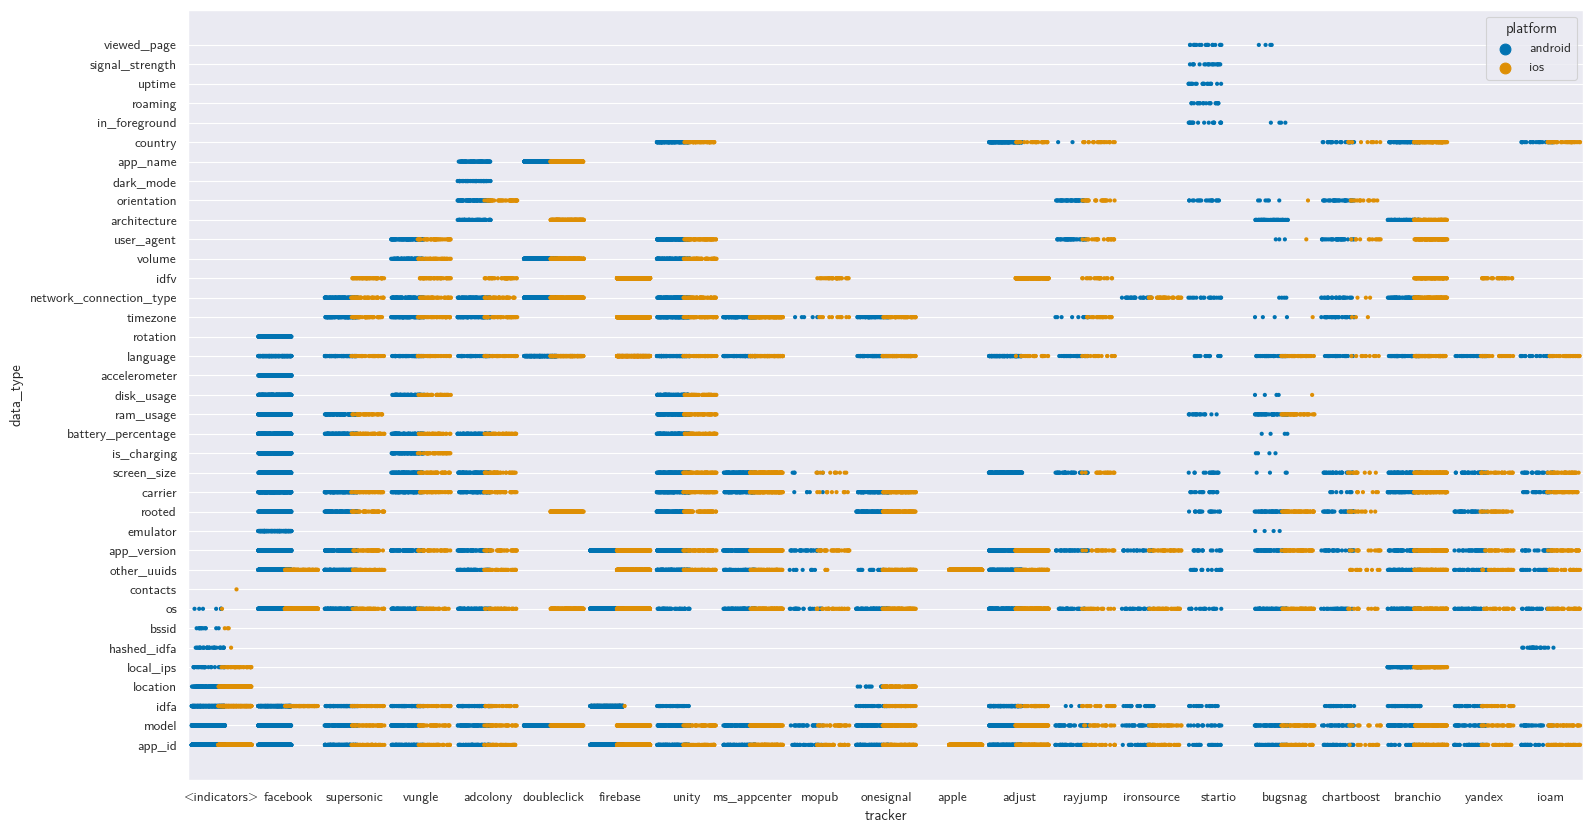

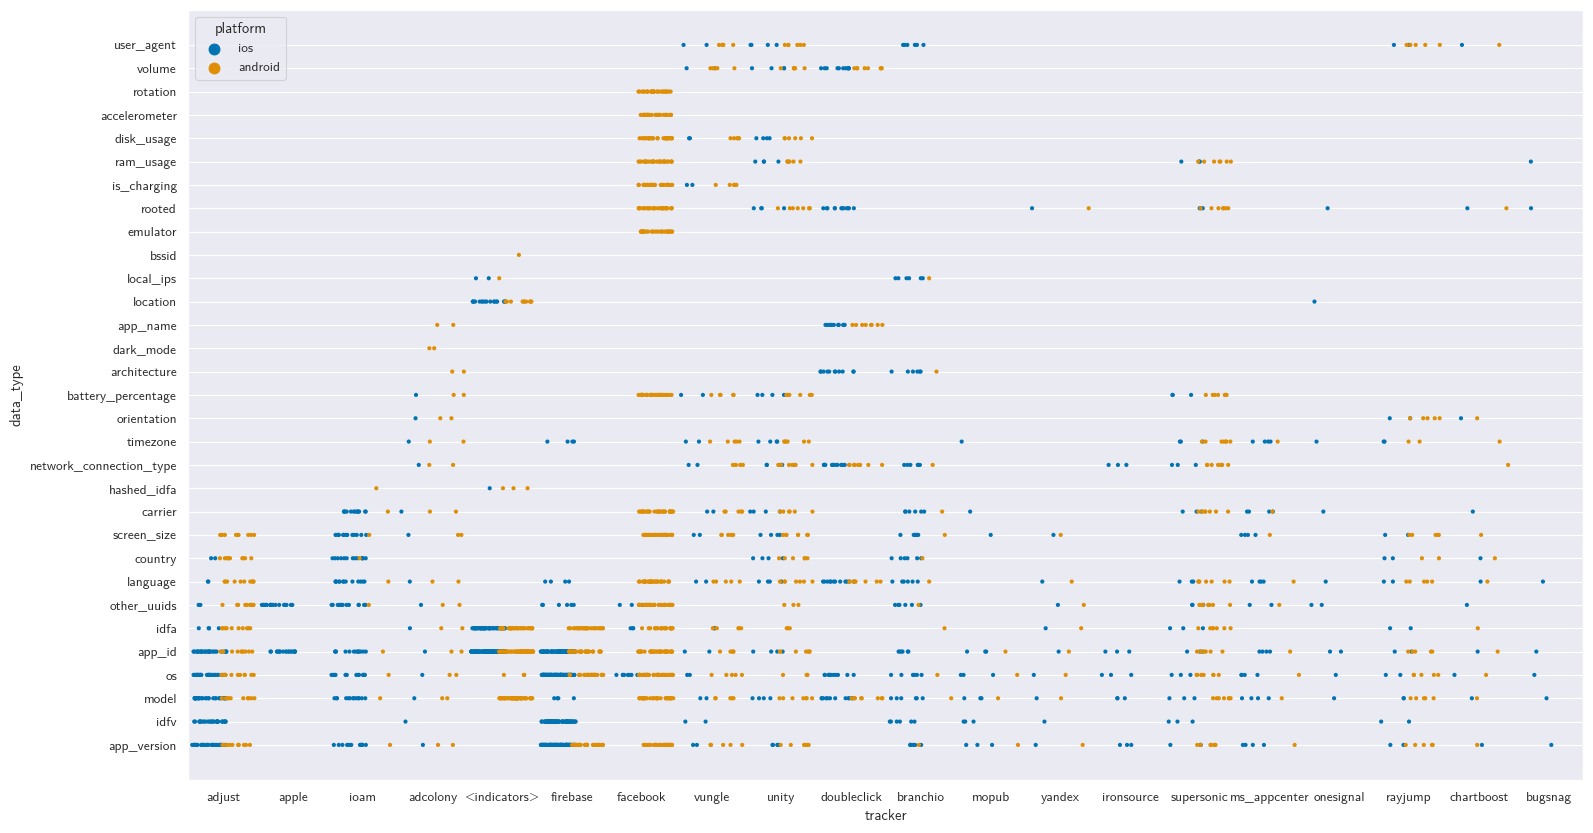

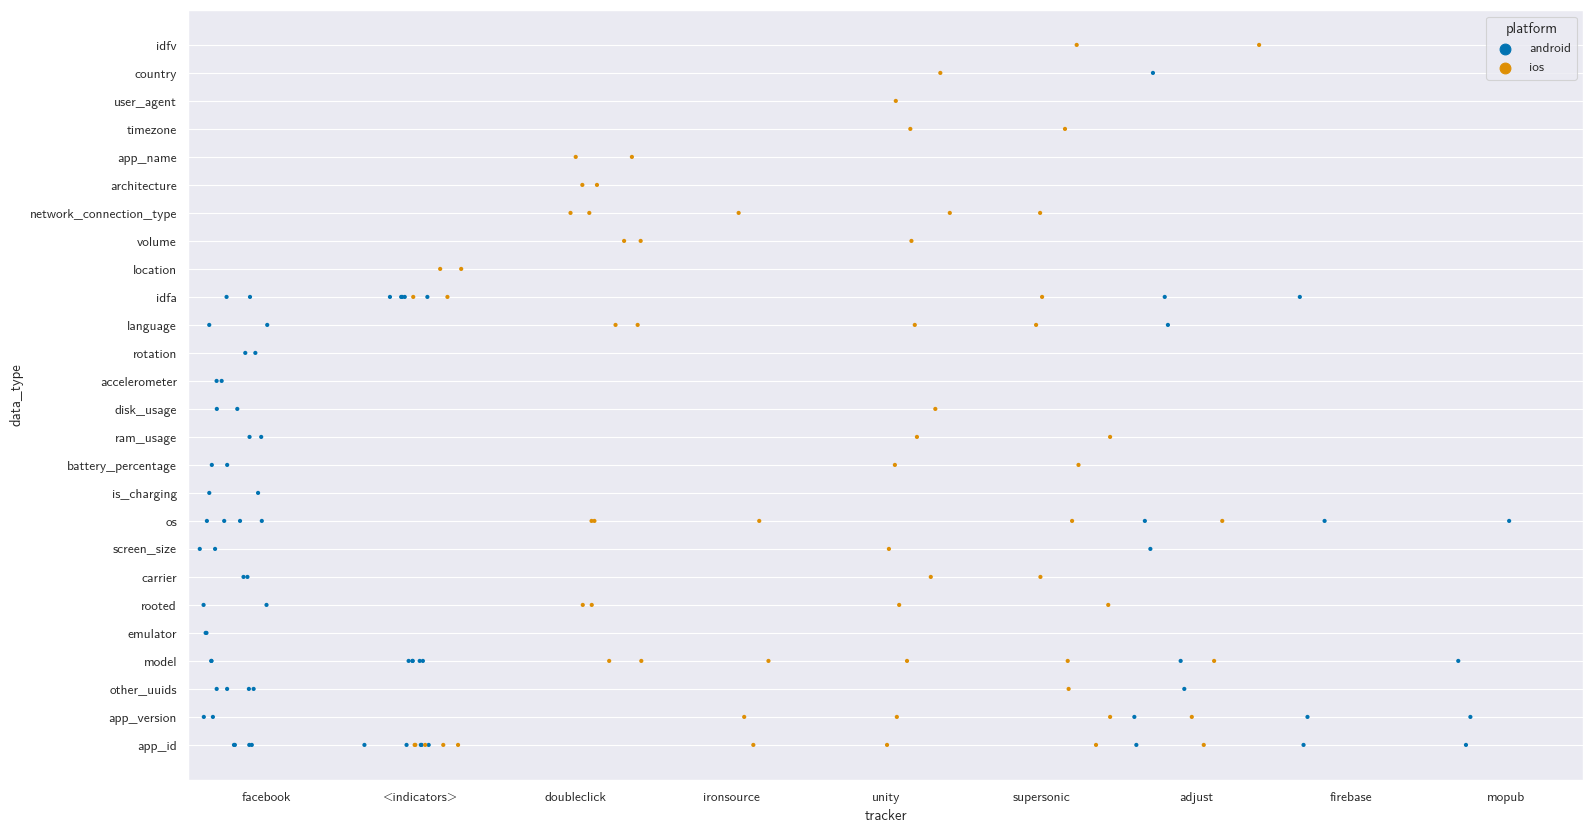

In [17]:
for type in ['initial', 'accepted', 'rejected']:
    csv = pd.read_csv(os.path.join(
        data_dir, f'apps_trackers_data_types_{type}.csv'), on_bad_lines='error')

    fig, ax = plt.subplots(figsize=[3*default_figsize_x, 2.5*default_figsize_y])
    sns.stripplot(x="tracker", y="data_type", hue="platform", jitter=0.5, dodge=True, size=3, data=csv, ax=ax)

    fig.savefig(os.path.join(graphs_dir, f'apps_trackers_data_types_{type}.pdf'),
                bbox_inches="tight", pad_inches=0)

# TODO: What about making one dot equal multiple (10?, 20?, whatever) apps to make it actually possible to gauge the
# amount of apps per tracker/data type.


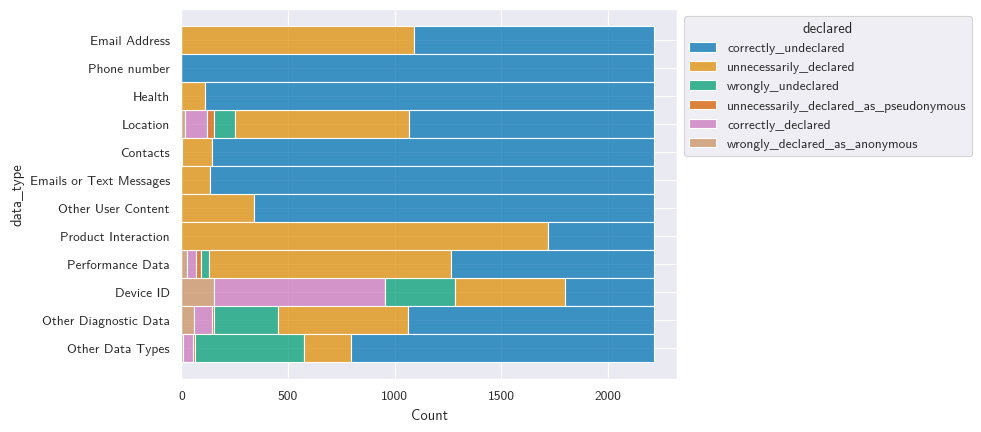

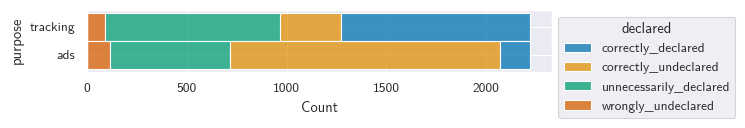

In [221]:
csv = pd.read_csv(os.path.join(
    data_dir, 'privacy_label_types.csv'), on_bad_lines='error')
fig, ax = plt.subplots()
sns.histplot(y="data_type", hue="declared", multiple="stack", data=csv, ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# TODO: These lists don't seem very suited for mobile.
csv = pd.read_csv(os.path.join(
    data_dir, 'privacy_label_purposes.csv'), on_bad_lines='error')
fig, ax = plt.subplots(figsize=[default_figsize_x, default_figsize_y * 0.2])
sns.histplot(y="purpose", hue="declared", multiple="stack", data=csv, ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


<AxesSubplot:xlabel='category', ylabel='company'>

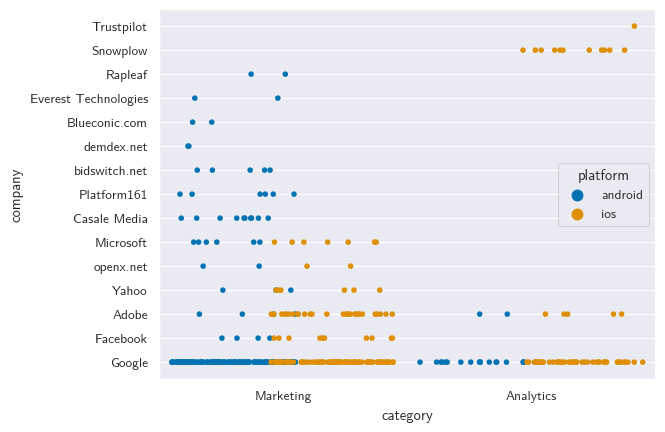

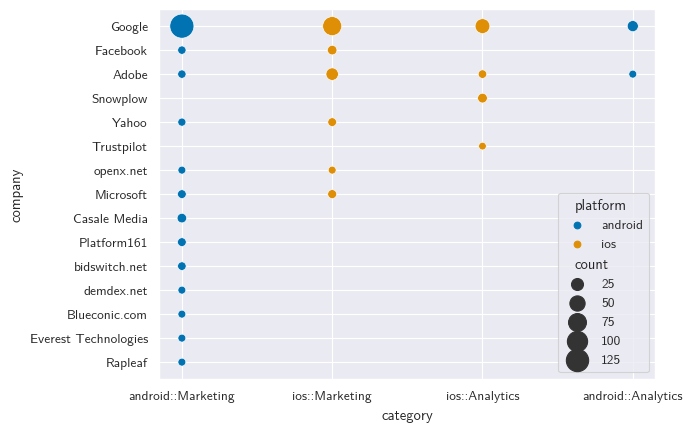

In [15]:
csv = pd.read_csv(os.path.join(
    data_dir, 'cookies.csv'), on_bad_lines='error')
fig, ax = plt.subplots()
sns.stripplot(x="category", y="company", hue="platform",
              jitter=0.5, dodge=True, size=4, data=csv, ax=ax)

csv = pd.read_csv(os.path.join(
    data_dir, 'cookie_counts.csv'), on_bad_lines='error')
fig, ax = plt.subplots()
sns.scatterplot(x="category", y="company", hue="platform",
              size="count", sizes=(30,300), data=csv, ax=ax)
